### Demonstration on how to read a given section of the Gray data with the session class

The session class is part of the GDa (Gray Data Analysis) package, and it is used to read and save the session info of the gray data in h5 format for further processing such as the pairwise coherence computation and temporal network analysis.

It can be imported as:

In [1]:
%matplotlib inline
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/GrayData-Analysis")

In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from frites.conn import define_windows

from GDa.session import session, session_info

pd.set_option("display.max_columns", None)

The session_info class will load the recording and trial information for a given session. These informations are stored on the files 'recording_info.mat' and 'trial_info.mat' and they contain the following information:

#### Recording info:
- image_locations: x,y location of images in degrees;
- image_names: names of the images;
- image_data: rgb matrices;
- channel_count: number of electrodes used during recording session;
- channel_numbers: electrode number;
- area: cell array containing the cortical area each electrode was in during recording session;
- depth: depth of each electrode during recording session;
- raw_data_sampling_rate: sampling rate of raw data
- calib_eye_sampling_rate: sampling rate of the eye data from Monkey Logic software
- number_sua: this is the number of single units on each electrode (note: all channels have mua);

#### Trial info:

- trial_type: 1 match-to-sample, 2 interleaved fixation trials, 3 blocked fixation trials, and 4 blank trials;
- sample_on: time that sample image was turned on (milliseconds);
- sample_off: time that sample image was turned off (milliseconds);
- match_on: time that the matching image and a distractor image are turned on (fixation point is simultaneously turned off);
- reaction_time: time taken for animal to make a saccade to the matching image;
- sample_image: number identifying which image was used for the sample;
- sample_location: number identifying the location of the sample image;
- match_image: number identifying the image that corresponds to the sample_image;
- match_location: number identifying the location of the matching image;
- nonmatch_image: number identifying the image that is not the matching image;
- nonmatch_location: number identifying the location of the non matching image;
- behavioral_response: 0 incorrect, 1 correct;
- num_trials: number of trials performed;

To instantiate a session_info class you have to call the constructor method and give the necessary parameters (go to the source code for further details):

In [3]:
info = session_info(
    raw_path="/home/vinicius/funcog/gda/GrayLab/",
    monkey="lucy",
    date="141017",
    session=1,
)

This will load the inforamtion for monkey lucy, recording sesssion 1 and date 150128. Let's print the keys of the dictionaries to check the information that we just read:

In [4]:
print("Recording informations:\n")
print(info.recording_info.keys())

Recording informations:

dict_keys(['image_locations', 'image_names', 'image_data', 'channel_count', 'channel_numbers', 'area', 'depth', 'lfp_sampling_rate', 'calib_eye_sampling_rate', 'number_sua', 'ms_mod', 'slvr'])


In [5]:
info.trial_info.head()

,behavioral_response,match_image,match_location,match_on,nonmatch_image,nonmatch_location,num_trials,reaction_time,sample_image,sample_location,sample_off,sample_on,trial_type
0,0.0,4.0,3.0,2963.0,1.0,7.0,777.0,119.0,4.0,1.0,1616.0,1097.0,1.0
1,0.0,2.0,6.0,2610.0,3.0,2.0,777.0,173.0,2.0,1.0,1544.0,1037.0,1.0
2,1.0,4.0,2.0,2835.0,2.0,6.0,777.0,168.0,4.0,1.0,1569.0,1063.0,1.0
3,0.0,4.0,9.0,2884.0,3.0,5.0,777.0,141.0,4.0,1.0,1564.0,1044.0,1.0
4,1.0,2.0,2.0,2615.0,3.0,6.0,777.0,154.0,2.0,1.0,1535.0,1015.0,1.0


Trials can be easily selected using the __trial_info__ DataFrame, for instance if one wants to get the trials were a ODRT with correct behavioral response hapened, the following can be done:

In [6]:
filtered_trials = info.trial_info[
    (info.trial_info["trial_type"] == 1.0)
    & (info.trial_info["behavioral_response"] == 1.0)
]
# Print the data frane
filtered_trials.head()

,behavioral_response,match_image,match_location,match_on,nonmatch_image,nonmatch_location,num_trials,reaction_time,sample_image,sample_location,sample_off,sample_on,trial_type
2,1.0,4.0,2.0,2835.0,2.0,6.0,777.0,168.0,4.0,1.0,1569.0,1063.0,1.0
4,1.0,2.0,2.0,2615.0,3.0,6.0,777.0,154.0,2.0,1.0,1535.0,1015.0,1.0
6,1.0,1.0,6.0,2348.0,4.0,2.0,777.0,248.0,1.0,1.0,1335.0,829.0,1.0
9,1.0,2.0,7.0,2748.0,1.0,3.0,777.0,216.0,2.0,1.0,1562.0,1055.0,1.0
10,1.0,1.0,2.0,2558.0,3.0,6.0,777.0,173.0,1.0,1.0,1398.0,878.0,1.0


To load the data the class __session__ should be used. The class session inherits from session_info consequently its constuctor method receives the same parameters. However a few other parameters should be provided:

1. slvr_msmod (boolean, default = False): wheter to read or not data from channels with slvr and ms_mod;
2. align_to (str, default = 'cue'): wheter to align to 'cue' or 'match';
4. evt_dt (list, default = [-0.65, 3.00]): the begining and end time of the time-series relative to the reference (cue or match).
5. save_to_h5 (boolean, default = False): wheter to save to data to an h5 file;
6. h5_path (str, default = None): the path to save the h5 file;

In [7]:
# Instantiate class
s = session(
    raw_path="/home/vinicius/funcog/gda/GrayLab/",
    monkey="lucy",
    date="141017",
    session=1,
    slvr_msmod=True,
    align_to="cue",
    evt_dt=[-0.65, 3.00],
    only_unique_recordings=False,
)

To load the data from the __.mat__ files, one can use the method __read_from_mat__. This will load all trial_types equals 1, 2, and 3 (1 match-to-sample, 2 interleaved fixation trials, 3 blocked fixation trials).

In [8]:
# Read data from .mat files
s.read_from_mat(load_spike_times=True, verbose=True)

100%|███████████████████████████████████████████████████████| 595/595 [00:13<00:00, 42.50it/s]


(595, 94, 3650)


100%|███████████████████████████████████████████████████████| 595/595 [00:21<00:00, 27.95it/s]


In [9]:
s.data[:, 0, :]

<xarray.DataArray (trials: 595, time: 3650)>
array([[ 1.83516755e-05,  1.07292881e-05, -1.68184569e-06, ...,
        -2.54464000e-05, -2.35770116e-05, -1.87155403e-05],
       [ 1.20263051e-06, -6.46111099e-06, -1.46249001e-05, ...,
         3.97091301e-05,  3.68605317e-05,  3.77359377e-05],
       [-2.22371544e-05, -2.41278520e-05, -1.69614940e-05, ...,
        -6.89550660e-06, -6.31498121e-06, -8.19328375e-06],
       ...,
       [-5.44857290e-05, -5.96368388e-05, -5.51790047e-05, ...,
         5.92708141e-05,  5.69752801e-05,  5.68192019e-05],
       [-4.08286427e-05, -3.59661878e-05, -3.76155121e-05, ...,
         1.93396654e-05,  2.22946331e-05,  2.29922333e-05],
       [-7.92044485e-05, -7.03911440e-05, -6.29533130e-05, ...,
         3.77181512e-05,  3.50395608e-05,  3.19041581e-05]])
Coordinates:
  * trials   (trials) int64 0 1 2 3 4 5 6 7 ... 766 768 769 771 772 773 774 775
    roi      <U13 'a46D'
  * time     (time) float64 -0.65 -0.649 -0.648 -0.647 ... 2.997 2.998 2.999
Attributes:
    nC:               94
    fsample:          1000.0
    channels_labels:  [  1   4   8   9  10  11  12  13  14  15  16  17  18  1...
    stim:             [ 4.  2.  4.  4.  2. nan  1.  5.  3.  2.  1.  3.  1.  2...
    indch:            [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ...
    t_cue_on:         [1097. 1037. 1063. 1044. 1015.  949.  829.  985. 1069. ...
    t_cue_off:        [1616. 1544. 1569. 1564. 1535. 1469. 1335. 1505. 1589. ...
    t_match_on:       [2963. 2610. 2835. 2884. 2615. 2962. 2348. 2958. 2641. ...

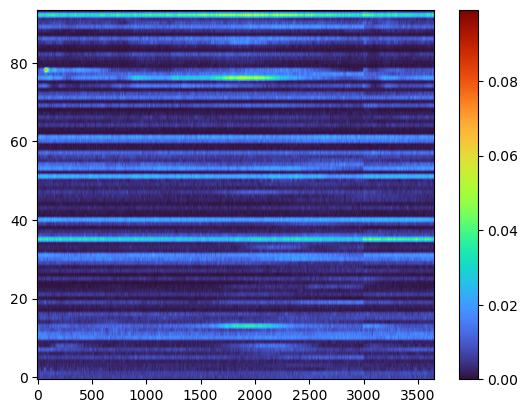

In [10]:
plt.imshow(s.spike_times.mean("trials"), aspect="auto", cmap="turbo", origin="lower")
plt.colorbar()

The data will be saved in an [xarray](http://xarray.pydata.org/en/stable/quick-overview.html#attributes) with three dimensions: trials, roi/channels, and time. The metadata is saved on the attributes dictionary.

In [11]:
print(s.data.shape)
print(s.spike_times.shape)

(595, 94, 3650)
(595, 94, 3650)


In [12]:
print("Session info.")
print("------------------------------------------------------------------")
print(s.data.attrs.keys())

Session info.
------------------------------------------------------------------
dict_keys(['nC', 'fsample', 'channels_labels', 'stim', 'indch', 't_cue_on', 't_cue_off', 't_match_on'])


The information stored in each of the keys in __readinfo__ is detailed bellow:

1. nC : Number of channels saved (not necessarily the total number of channels in the data);
2. fsample : Frequency sample of the LFP signal.
3. channels_labels : Array containing the original channels labels.
4. stim : Stimulus label for each of the trials used.
5. indch: Index of the channels used.
6. t_cue_on: The time at which cue was turned on.
7. t_cue_off: The time at which cue was turned off.
8. t_match_on: The time at which match was turned on.

One can do all kind of filtering to the data, as aforementioned, the DataFrame __trial_info__ can be used to do so. Let's supose that one wants only the LFP data for coorect trials of the type 1 (ODRT). 

In [13]:
s.trial_info.head()

,trial_index,behavioral_response,match_image,match_location,match_on,nonmatch_image,nonmatch_location,num_trials,reaction_time,sample_image,sample_location,sample_off,sample_on,trial_type
0,0,0.0,4.0,3.0,2963.0,1.0,7.0,777.0,119.0,4.0,1.0,1616.0,1097.0,1.0
1,1,0.0,2.0,6.0,2610.0,3.0,2.0,777.0,173.0,2.0,1.0,1544.0,1037.0,1.0
2,2,1.0,4.0,2.0,2835.0,2.0,6.0,777.0,168.0,4.0,1.0,1569.0,1063.0,1.0
3,3,0.0,4.0,9.0,2884.0,3.0,5.0,777.0,141.0,4.0,1.0,1564.0,1044.0,1.0
4,4,1.0,2.0,2.0,2615.0,3.0,6.0,777.0,154.0,2.0,1.0,1535.0,1015.0,1.0


In [14]:
idx = s.trial_info[
    (s.trial_info["trial_type"] == 1.0) & (s.trial_info["behavioral_response"] == 1.0)
].trial_index.values

In [39]:
data_filtered = s.data.sel(trials=idx)

In [46]:
print(f"{data_filtered.shape=}")

data_filtered.shape=(332, 94, 3650)


In [45]:
data_filtered = s.spike_times.sel(trials=idx)

In [18]:
spikes = data_filtered.sel(time=slice(-0.5, 2))

win, twin = define_windows(spikes.time.data, slwin_len=20 / 1000, slwin_step=20 / 1000)

spike_rates = []
for ti, tf in win:
    spike_rates += [spikes.isel(time=slice(ti, tf)).sum("time")]
spike_rates = xr.concat(spike_rates, "times")
spike_rates = spike_rates.assign_coords({"times": twin})

Defining temporal windows (sfreq=999.9999999999991)
    Definition of sliding windows (len=0.02, start=-0.4999999999999999, stop=1.9990000000000023, step=0.02)


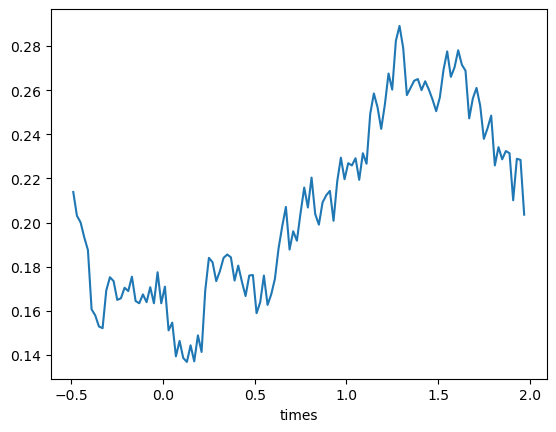

In [19]:
spike_rates.sel(roi="V1").mean(("trials", "roi")).plot()

### Plotting a few trials of the data

In [20]:
trials = np.random.choice(data_filtered.trials, size=5)

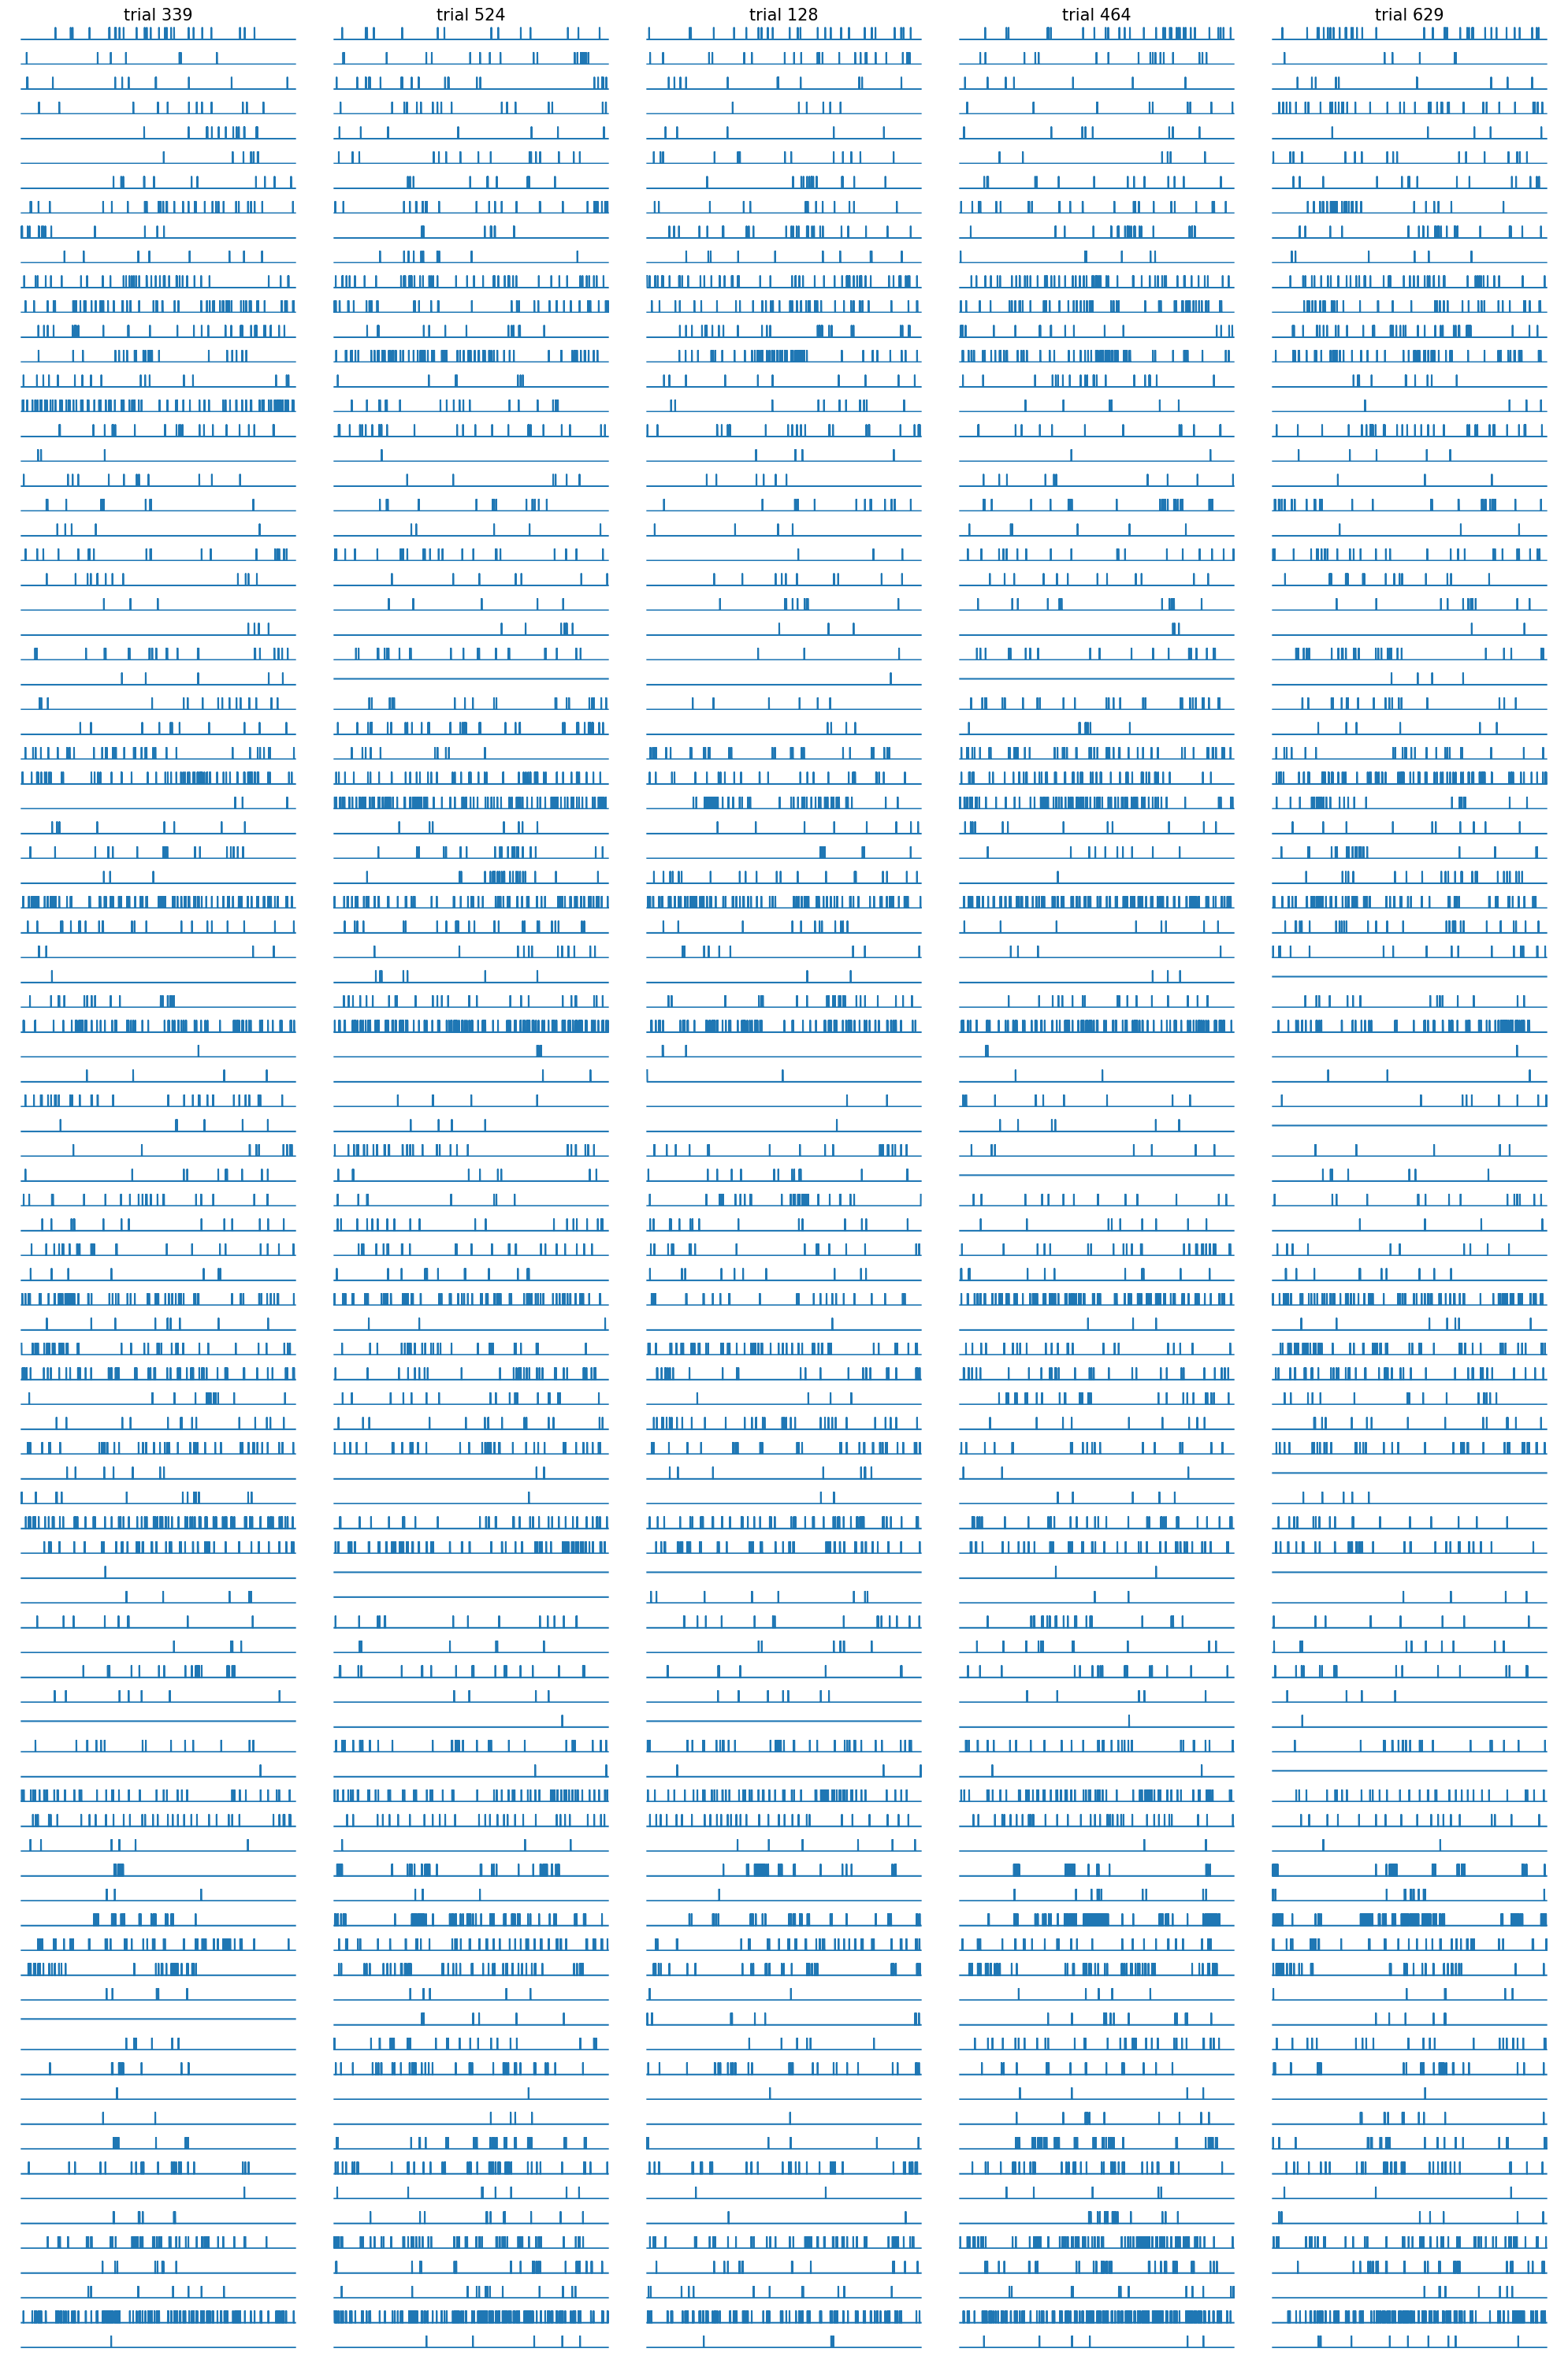

In [21]:
plt.figure(figsize=(20, 30))
pos = 1
for c in range(data_filtered.sizes["roi"]):
    for t in trials:
        plt.subplot(data_filtered.sizes["roi"], len(trials), pos)
        plt.plot(data_filtered.isel(roi=c).sel(trials=t))
        plt.axis("off")
        if c == 0:
            plt.title(f"trial {t}", fontsize=15)
        if t == trials[0]:
            plt.ylabel(data_filtered.roi[c].values, fontsize=15, rotation=0)
        pos += 1
plt.tight_layout()

In [22]:
data_filtered = data_filtered.isel(
    roi=[0, 2, 3, 5, 6, 7, 8, 9, 10, 13, 14, 16, 19, 22, 23, 27, 30, 31, 33, 34]
).sortby("roi", ascending=False)

In [23]:
data_filtered = data_filtered * 1e6

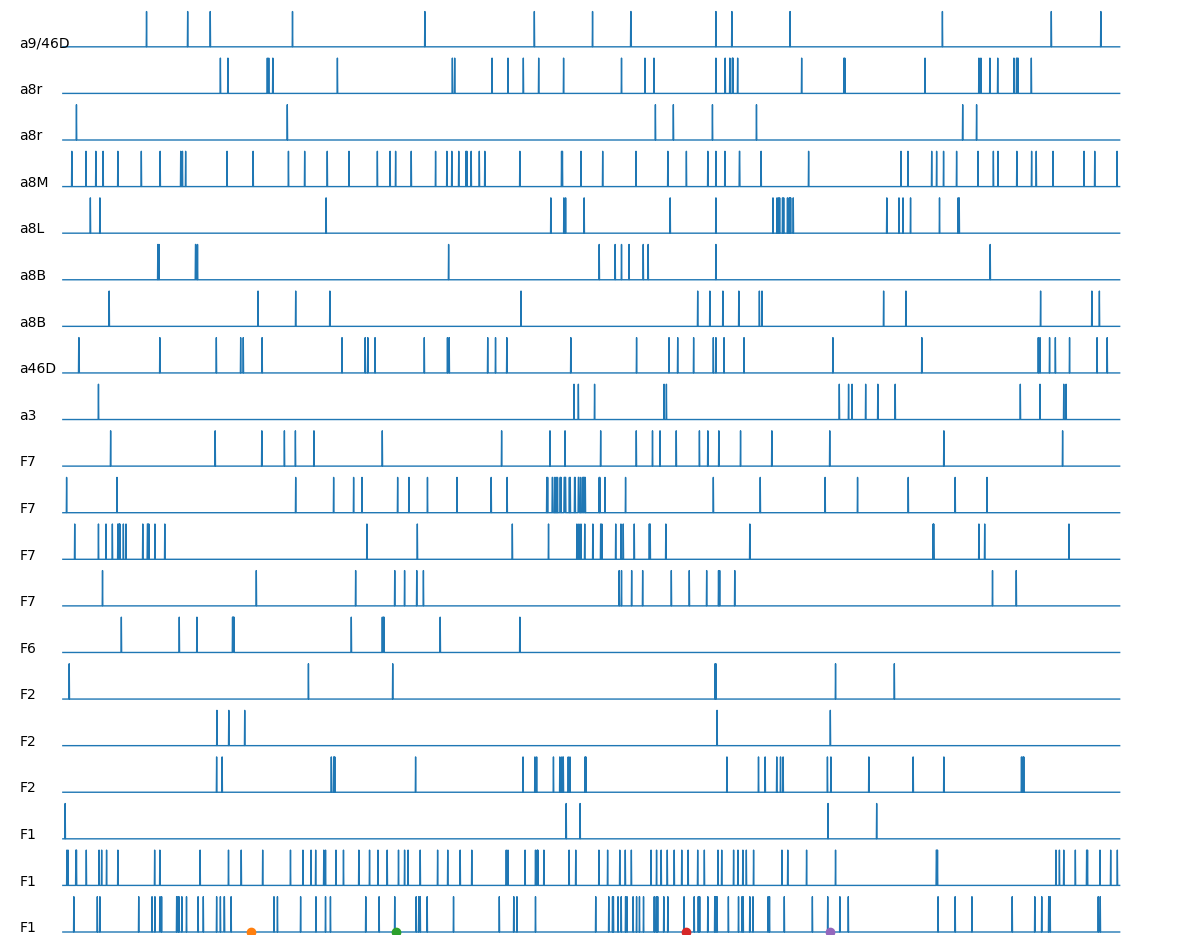

In [24]:
plt.figure(figsize=(15, 12))
pos = 1
for i in range(data_filtered.sizes["roi"]):
    ax = plt.subplot(20, 1, pos)
    data_filtered.sel(trials=249).isel(roi=i).plot(lw=1)
    plt.text(-0.8, 15e-6, f"{data_filtered.roi.data[i]}")
    plt.axis("off")
    plt.xlabel("")
    plt.title("")
    if i == data_filtered.sizes["roi"] - 1:
        plt.plot(0, 0, "o")
        plt.plot(0.5, 0, "o")
        plt.plot(1.5, 0, "o")
        plt.plot(2, 0, "o")
    pos += 1
    [ax.spines[key].set_visible(False) for key in ["top", "right"]]
    plt.savefig("recordings.pdf", dpi=600)

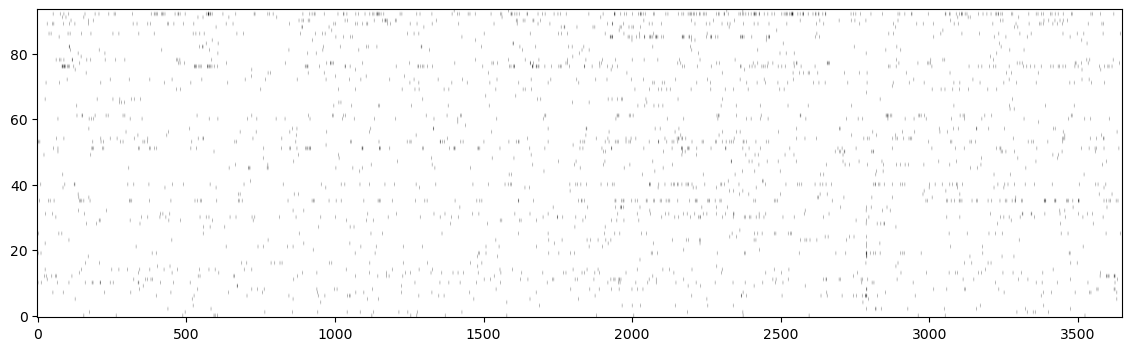

In [54]:
plt.figure(figsize=(14, 4))
plt.imshow(data_filtered[251], aspect="auto", cmap="binary", origin="lower")

In [47]:
data_filtered

<xarray.DataArray (trials: 332, roi: 94, time: 3650)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * trials   (trials) int64 2 4 6 9 10 13 14 15 ... 658 659 661 663 765 768 773
  * roi      (roi) <U13 'a46D' 'a8B' 'F6' 'a9/46D' 'a8M' ... 'V1' 'V1' 'V1' 'V1'
  * time     (time) float64 -0.65 -0.649 -0.648 -0.647 ... 2.997 2.998 2.999
Attributes:
    nC:               94
    fsample:          1000.0
    channels_labels:  [  1   4   8   9  10  11  12  13  14  15  16  17  18  1...
    stim:             [ 4.  2.  4.  4.  2. nan  1.  5.  3.  2.  1.  3.  1.  2...
    indch:            [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 ...
    t_cue_on:         [1097. 1037. 1063. 1044. 1015.  949.  829.  985. 1069. ...
    t_cue_off:        [1616. 1544. 1569. 1564. 1535. 1469. 1335. 1505. 1589. ...
    t_match_on:       [2963. 2610. 2835. 2884. 2615. 2962. 2348. 2958. 2641. ...